## 2024 El Nino Cruise CTD data transects<br>
This notebook details our process for loading, cleaning, interpolating, and plotting 2024 CTD data for later mixing metric use. <br>
Note that this notebook utilizes both code from Susan Hautala and code inspired by ChatGPT

In [1]:
# dependencies
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d as interp

### Let's start by loading the CTD data

In [2]:
# function for extracting coordinates from CTD files
def get_coords(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Search for lines containing latitude and longitude information
    latitude = None
    longitude = None
    
    for line in lines:
        if line.startswith('* NMEA Latitude'):
            components = line.split('=')
            lat_degrees, lat_minutes, lat_direction = components[1].strip().split()
            latitude = float(lat_degrees) + float(lat_minutes) / 60
            if lat_direction == 'S':
                latitude *= -1  # For southern hemisphere, change latitude to negative
    
        elif line.startswith('* NMEA Longitude'):
            components = line.split('=')
            lon_degrees, lon_minutes, lon_direction = components[1].strip().split()
            longitude = float(lon_degrees) + float(lon_minutes) / 60
            if lon_direction == 'W':
                longitude *= -1  # For western hemisphere, change longitude to negative
    return latitude, longitude

key for CTD data <br>
P = Pressure <br>
T = Temperature from the primary sensor<br>
S = Salinity Practical from the primary sensor  <br>
D = Potential Density <br>
We'll store the data as a dictionary of pandas dataframes

In [3]:
# function for extracting data from ctd files. we will use the primary temp and salinity sensors and potential density
def extract_ctd_edit(datadir, cast_ids, coord_ids, skip_header1, skip_header2): # added coord_ids due to problems with initial attempts. Coord_ids are original files, cast_ids are updated dilemeters in _val files
    dict = {'cast_ids': cast_ids} # initialize main dictionary with cast_ids
    
    cast_num = len(cast_ids) # find num casts
    coords =  pd.DataFrame() # set up coord df
    for wp in range(cast_num): # more problems require a change in skip_header for the final 3 files.
        cast = datadir + cast_ids[wp] + '.cnv' # get filepath
        if wp <= 9:
            P, T, S, D, D_10 = np.genfromtxt(fname=cast,usecols=(2,3,13,15,24), # D_10 is new TEOS 10
                                       skip_header=skip_header1,unpack=True, encoding='iso-8859-1') # get data from CTD file ### SKIPHEADER 1
            
            wp_data = {'P':P,'T':T, 'S':S, 'D':D, 'D_10' : D_10} # put wp data into temp_dictionary
            wp_data_df = pd.DataFrame(wp_data) # convert temp_dictionary to df
    
            
            dict[cast_ids[wp]] = wp_data_df # put wp DataFrame into main dictionary
            
            #print(P.size,'wp size') # get progress of data extraction and quantify file sizes
            coord_cast = datadir + coord_ids[wp] + '.cnv' # get coord filepath
            wp_lat, wp_lon = get_coords(coord_cast) # get coords from CTD file
            coords[cast_ids[wp]] = wp_lat, wp_lon # put coords in coords df
        if wp > 9:
            P, T, S, D, D_10 = np.genfromtxt(fname=cast,usecols= (2,3,13,15,24), # D_10 is new TEOS 10
                                       skip_header=skip_header2,unpack=True, encoding='iso-8859-1') # get data from CTD file ### SKIPHEADER 2
            
            wp_data = {'P':P,'T':T, 'S':S, 'D':D, 'D_10' : D_10} # put wp data into temp_dictionary
            wp_data_df = pd.DataFrame(wp_data) # convert temp_dictionary to df
    
            
            dict[cast_ids[wp]] = wp_data_df # put wp DataFrame into main dictionary
            
            #print(P.size,'wp size') # get progress of data extraction and quantify file sizes
            coord_cast = datadir + coord_ids[wp] + '.cnv' # get coord filepath
            wp_lat, wp_lon = get_coords(coord_cast) # get coords from CTD file
            coords[cast_ids[wp]] = wp_lat, wp_lon # put coords in coords df
        
    dict['coords'] = coords # put coords df into main dictionary
    return dict

In [4]:
cast_ids = ['TN4270301d_val', 'TN4270401d_val', 'TN4270501d_val', 'TN4270601d_val', 'TN4270701d_val', 'TN4270801d_val', 'TN4270901d_val', 
            'TN4271001d_val', 'TN4271101d_val', 'TN4271201d_val', 'TN4271301d_val', 'TN4271401d_val', 'TN4271502d_val']
coord_ids = ['TN4270301d', 'TN4270401d', 'TN4270501d', 'TN4270601d', 'TN4270701d', 'TN4270801d', 'TN4270901d', 
            'TN4271001d', 'TN4271101d', 'TN4271201d', 'TN4271301d', 'TN4271401d', 'TN4271502d']
dict = extract_ctd_edit('data/2024/ctd/', cast_ids, coord_ids, 382,387)

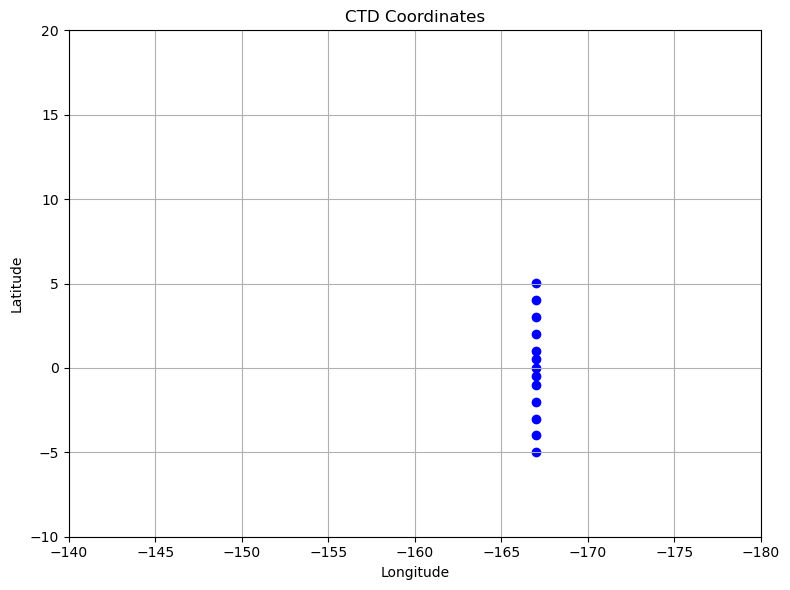

In [5]:
# Extract latitudes and longitudes
coords = dict['coords']
latitudes = np.array(coords.loc[0])
longitudes = np.array(coords.loc[1])

plt.figure(figsize=(8, 6))
plt.scatter(longitudes, latitudes, color='blue', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('CTD Coordinates')

#plt.xticks(
#    np.linspace(-360, 360, 13),  # Locations of the ticks
#    ['0', '30', '60', '90', '120', '150', '180','150', '120', '90', '60', '30', '0']  # Labels
#)

# Zoom in by setting limits for better visualization
plt.xlim(-140,-180)
plt.ylim(-10, 20)

plt.grid(True)
plt.tight_layout()
plt.show()

Transect along 167 W looks good. We have excluded CTD cast 1501 because it only goes to 200 meters.

#### We have code to get the data now, but it needs some cleaning and and processing before it is ready for use. We define below a number of functions to achieve this, then we apply them to the data, then we plot <br>
Though the downcast has already been isolated in our files, this ensures another file inputed extracts the downcast and removes pressure bounces

In [6]:
# Isolate the down cast and get rid of any "bounces" to lower pressure 
# because the mixing package needs a monotonic "depth" coordinate.
# We will use pressure as a metric of depth
def down_clean(dict, pmax): # pmax corresponds to the max pressure (or depth) to ensure data uniformity
    down_dict = dict # generate output dictionary
    
    for wp in dict['cast_ids']: # iterate through each CTD wp
        down_df = pd.DataFrame([])# generate output df
        wp_df = dict[wp] # set working df
        
        # set data holders
        P, T, S, D, D_10 = wp_df['P'], wp_df['T'], wp_df['S'], wp_df['D'], wp_df['D_10']
        
        ipmax = np.where(round(P)==pmax)[0][0] # find max depth
        ipmin=0
        pmin = P[0]
        for i in range(1,ipmax):
            if P[i]<pmin:
                ipmin=i
                pmin = P[i]

        # set down_cast lists
        P_down=[]
        T_down=[]
        S_down=[]
        D_down=[]
        D_10_down=[]
        
        P_bounce=0.0
        bounceCount = 0

        # put down_cast data into down_cast dfs
        for i in range(ipmin,ipmax):
            if P[i]>P_bounce:
                P_down.append(P[i])
                P_bounce=P[i]
                S_down.append(S[i])
                T_down.append(T[i])
                D_down.append(D[i])
                D_10_down.append(D_10[i])
            else:
                bounceCount = bounceCount+1
                
        # plug into updated dataframes
        down_df['P'], down_df['T'], down_df['S'], down_df['D'], down_df['D_10'] = P_down, T_down, S_down, D_down, D_10_down

        # append to dictionary
        down_dict[wp] = down_df
    
    return down_dict

Let's bin average it into bins to achieve uniformity of data shapes

In [7]:
def bin_average(list, num_bins): # a sub_function that bin-averages a list of data
    _, bin_edges = np.histogram(np.arange(len(list)), bins=num_bins) # bin data
    b_avg = [np.mean(list[int(start):int(end)]) for start, end in zip(bin_edges[:-1], bin_edges[1:])] # avg data by bin
    return b_avg

def dict_bin_average(dict, num_bins): # apply bin_averaging to entire dictionary
    binned_dict = dict # generate output dictionary
    for wp in dict['cast_ids']: # iterate through each CTD wp
        binned_df = pd.DataFrame([])# generate output df
        wp_df = dict[wp] # set working df
        
        # set data holders
        P, T, S, D, D_10 = wp_df['P'], wp_df['T'], wp_df['S'], wp_df['D'], wp_df['D_10']
        
        # bin average
        P_bin, T_bin, S_bin, D_bin, D_bin10 = bin_average(P, num_bins), bin_average(T, num_bins), bin_average(S, num_bins), bin_average(D, num_bins), bin_average(D_10, num_bins)

        # plug into updated dataframes
        binned_df['P'], binned_df['T'], binned_df['S'], binned_df['D'], binned_df['D_10'] = P_bin, T_bin, S_bin, D_bin, D_bin10
        
        # append to dictionary
        binned_dict[wp] = binned_df

    return binned_dict

Let's clean outliers by setting points past 3 standard deviations of the mean to the nearest good value.<br>

In [8]:
def replace_bad(df): # a sub_function that finds and replaces 'bad' values with nearest 'good' data
    clean_list = np.array(df) # initialize clean list for indexing
    working_list = np.array(df) # set working df as a list for indexing 
    
    # calculate mean and standard deviation
    df_mean = np.mean(df)
    df_std = np.std(df)
    
    # define 'bad' vals as > or < 3 stds and set to NaN
    bad_to_NaN = np.where((df > (df_mean + 3 * df_std)) | (df < (df_mean - 3 * df_std)), np.nan, df)
    # get indices of NaN values
    nan_ind = np.where(np.isnan(bad_to_NaN))[0]
    # replace NaN vals with the nearest non-NaN val
    for idx in nan_ind:
        found = False # initialize conditional
        deviation = 1 # set search step
        while found is False: # search for nearest non-NaN val
            if idx + deviation not in nan_ind and idx != len(working_list): 
                clean_list[idx] = working_list[idx + deviation]
                found = True
            if idx - deviation not in nan_ind and idx != 0:
                clean_list[idx] = working_list[idx - deviation]
                found = True   
            deviation += 1 # check a step further
            
    clean_df = pd.DataFrame(clean_list) # return clean list to dataframe
    
    return clean_df


# function to clean outliers from a dictionary using the replace_bad sub_function
def clean_outliers(dict):
    clean_dict = dict # generate output dictionary
    for wp in dict['cast_ids']: # iterate through each CTD wp
        clean_df = pd.DataFrame([])# generate output df
        wp_df = dict[wp] # set working df
        
        # set data holders
        P, T, S, D, D_10 = wp_df['P'], wp_df['T'], wp_df['S'], wp_df['D'], wp_df['D_10']

        # clean data of 'bad' and NaN values
        P_clean = replace_bad(P)
        T_clean = replace_bad(T)
        S_clean = replace_bad(S)
        D_clean = replace_bad(D)
        D_10_clean = replace_bad(D_10)

        # plug into updated dataframes
        clean_df['P'], clean_df['T'], clean_df['S'], clean_df['D'], clean_df['D_10'] = P_clean, T_clean, S_clean, D_clean, D_10_clean

        # append to dictionary
        clean_dict[wp] = clean_df
    
    return clean_dict

Let's convert to P,T,S,D dataframes

In [9]:
def df_conversion(dict):
    # initialize dataframes
    P, T, S, D, D_10 = pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([])
    for wp in dict['cast_ids']: # iterate through each CTD wp and collect P,T,S,D values into dataframes
        wp_df = dict[wp] # set working df
        
        # append data to corresponding df
        P[wp], T[wp], S[wp], D[wp], D_10[wp] = wp_df['P'], wp_df['T'], wp_df['S'], wp_df['D'], wp_df['D_10']
    return P, T, S, D, D_10

### The last step is to interpolate between casts

In [10]:
# coords define horizontal values
# ydf is value df corresponding to pressure, temp, salinity, and pot density
# transect controls the total number of points interpolated along the x axis
def interpolate_df(coords, ydf, transect):
    interpolated_values = []
    lats = coords.iloc[0]
    
    for layer in range(len(ydf)):
        vals = ydf.iloc[layer] # get vals for layer
        
        # sort vals and lats in monotonically increasing order:
        sorted_indices = np.argsort(lats)
        coords_sorted = lats[sorted_indices]
        vals_sorted = vals[sorted_indices]
        
        f = np.interp(transect, coords_sorted, vals_sorted)  # perform linear interpolation
        interpolated_values.append(f)

    interp_df = pd.DataFrame(interpolated_values).T  # output df
    return interp_df

In [11]:
cast_ids = ['TN4270301d_val', 'TN4270401d_val', 'TN4270501d_val', 'TN4270601d_val', 'TN4270701d_val', 'TN4270801d_val', 'TN4270901d_val', 
            'TN4271001d_val', 'TN4271101d_val', 'TN4271201d_val', 'TN4271301d_val', 'TN4271401d_val', 'TN4271502d_val']
coord_ids = ['TN4270301d', 'TN4270401d', 'TN4270501d', 'TN4270601d', 'TN4270701d', 'TN4270801d', 'TN4270901d', 
            'TN4271001d', 'TN4271101d', 'TN4271201d', 'TN4271301d', 'TN4271401d', 'TN4271502d']
dict = extract_ctd_edit('data/2024/ctd/', cast_ids, coord_ids, 382,387) # reload data, excluding CTD casts identified above
w_dict = dict # set working dict
print('initial data extraction complete')

depth_cutoff = 650 # cutoff depth at 650 meters to match to ADCP data
num_bins = 500 # average into 650 bins 1 meter deep
resolution = 111 * 10 # set total num points along latitude for interpolation. Interpolate every 2 km


down_dict = down_clean(w_dict, depth_cutoff) # select downcast, remove bounces
w_dict = down_dict # update working dict
print('downcasted and debounced')

binned_dict = dict_bin_average(w_dict, num_bins) # average into bins
w_dict = binned_dict # update working dict
print('binned')

clean_dict = clean_outliers(w_dict) # clean data of outliers
w_dict = clean_dict # update working dict
print('nans and outliers cleaned')

P, T, S, D, D_10 = df_conversion(w_dict) # convert dictionary to dataframes for each variable
print('converted to df')

# finally, interpolate by latitude for each variable dataframe

coords = dict['coords'] # grab coord values
transect = np.linspace((coords.iloc[0])[0], (coords.iloc[0])[len(coords.iloc[0]) - 1], resolution) # generate transect along latitude axis

P_int = (interpolate_df(coords, P, transect)).T
T_int = (interpolate_df(coords, T, transect)).T
S_int = (interpolate_df(coords, S, transect)).T
D_int = (interpolate_df(coords, D, transect)).T
D_10_int = (interpolate_df(coords, D_10, transect)).T
print('interpolated')

initial data extraction complete
downcasted and debounced
binned
nans and outliers cleaned
converted to df
interpolated


In [35]:
# set latitude transects as a df of shape P for contourf plotting
transect_holder = []
for i in range(len(P_int)):
    transect_holder.append(transect)
transect_df = pd.DataFrame(transect_holder)

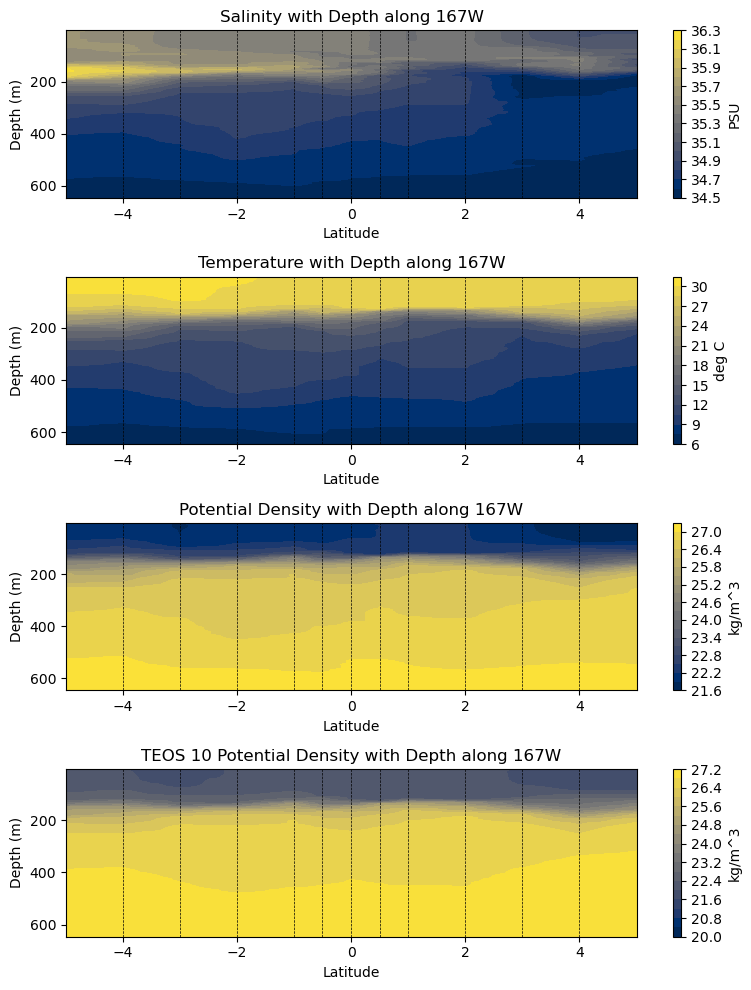

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10))

# plotting Salinity (S_int) with depth along the transect
contour_S = axes[0].contourf(transect_df, P_int, S_int, levels=20, cmap='cividis')
axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Depth (m)')
axes[0].set_title('Salinity with Depth along 167W')
for cast in coords.iloc[0]:
    axes[0].axvline(x=cast, color='k', linestyle='--', linewidth = 0.5, label='CTD Cast')
axes[0].invert_yaxis()
cbar_S = plt.colorbar(contour_S, ax=axes[0])
cbar_S.set_label('PSU')

# plotting Temperature (T_int) with depth along the transect
contour_T = axes[1].contourf(transect_df, P_int, T_int, levels=20, cmap='cividis')
axes[1].set_xlabel('Latitude')
axes[1].set_ylabel('Depth (m)')
axes[1].set_title('Temperature with Depth along 167W')
for cast in coords.iloc[0]:
    axes[1].axvline(x=cast, color='k', linestyle='--', linewidth = 0.5, label='CTD Cast')
axes[1].invert_yaxis()
cbar_T = plt.colorbar(contour_T, ax=axes[1])
cbar_T.set_label('deg C')

# plotting Potential Density (D_int) with depth along the transect TEOS9
contour_D = axes[2].contourf(transect_df, P_int, D_int, levels=20, cmap='cividis')
axes[2].set_xlabel('Latitude')
axes[2].set_ylabel('Depth (m)')
axes[2].set_title('Potential Density with Depth along 167W')
for cast in coords.iloc[0]:
    axes[2].axvline(x=cast, color='k', linestyle='--', linewidth = 0.5, label='CTD Cast')
axes[2].invert_yaxis()
cbar_D = plt.colorbar(contour_D, ax=axes[2])
cbar_D.set_label('kg/m^3')

# plotting Potential Density (D_int) with depth along the transect TEOS10
contour_D = axes[3].contourf(transect_df, P_int, D_10_int, levels=20, cmap='cividis')
axes[3].set_xlabel('Latitude')
axes[3].set_ylabel('Depth (m)')
axes[3].set_title('TEOS 10 Potential Density with Depth along 167W')
for cast in coords.iloc[0]:
    axes[3].axvline(x=cast, color='k', linestyle='--', linewidth = 0.5, label='CTD Cast')
axes[3].invert_yaxis()
cbar_D = plt.colorbar(contour_D, ax=axes[3])
cbar_D.set_label('kg/m^3')

plt.tight_layout()

### Let's save the cleaned CTD dataframes as cnvs

In [14]:
P_int.to_csv('data/2024/ctd/cleaned/P_int.csv', index=False)
T_int.to_csv('data/2024/ctd/cleaned/T_int.csv', index=False)
S_int.to_csv('data/2024/ctd/cleaned/S_int.csv', index=False)
D_int.to_csv('data/2024/ctd/cleaned/D_int.csv', index=False)
transect_df.to_csv('data/2024/ctd/cleaned/lat_df.csv', index=False)

In [37]:
# and saving non-interpolated CTD data:
P.to_csv('data/2024/ctd/cleaned/P.csv', index=False)
T.to_csv('data/2024/ctd/cleaned/T.csv', index=False)
S.to_csv('data/2024/ctd/cleaned/S.csv', index=False)
D.to_csv('data/2024/ctd/cleaned/D.csv', index=False)
coords.to_csv('data/2024/ctd/cleaned/coords.csv', index=False)